# ECAL Laser correction with Deep Learning

Train a regression of the CMS ECAL transparency correction, using the information
collected from the previous five readouts

The input dataset consists of ROOT files with plain TTrees. Each file corresponds to a single crystal.

In [1]:
# download the dataset
! wget https://github.com/pierinim/tutorials/blob/master/RTA_Workshop/data.tar.gz?raw=true -O "data.tar.gz"
! tar -xzf data.tar.gz
! ls

--2019-07-17 12:12:59--  https://github.com/pierinim/tutorials/blob/master/RTA_Workshop/data.tar.gz?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pierinim/tutorials/raw/master/RTA_Workshop/data.tar.gz [following]
--2019-07-17 12:13:00--  https://github.com/pierinim/tutorials/raw/master/RTA_Workshop/data.tar.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pierinim/tutorials/master/RTA_Workshop/data.tar.gz [following]
--2019-07-17 12:13:00--  https://raw.githubusercontent.com/pierinim/tutorials/master/RTA_Workshop/data.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... con

In [2]:
!ls data

BlueLaser_2017_rereco_v2_newformat.root.filter.10.131.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.10.132.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.10.133.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.10.134.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.10.135.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.10.136.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.10.137.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.10.138.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.10.139.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.11.131.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.11.132.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.11.133.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.11.134.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.11.135.0.public.root
BlueLaser_2017_rereco_v2_newformat.root.filter.1

In [3]:
# we first install uproot to read the input data 
# and convert them to a numpy array
! pip install uproot

     |████████████████████████████████| 112kB 5.2MB/s 
     |████████████████████████████████| 92kB 26.9MB/s 


In [0]:
import uproot as ur
import numpy as np

In [0]:
iXrange = range(6,25)
iYrange = range(131,140)

In [0]:
transparency = np.array([])
time = np.array([])
time_in_fill = np.array([])
lumi = np.array([])
iX = np.array([])
iY = np.array([])
for i in iXrange:
    for j in iYrange:
        file = ur.open("data/BlueLaser_2017_rereco_v2_newformat.root.filter.%i.%i.0.public.root" %(i,j))
        ecalModule = file.get('laser')
        my_transparency = ecalModule["transparency"].array()
        my_size = my_transparency.shape[0]
        my_transparency = np.reshape(my_transparency, (my_size,1))
        my_time = ecalModule["time"].array()
        my_time = np.reshape(my_time, (my_size,1))
        my_time_in_fill = ecalModule["time_in_fill"].array()
        my_time_in_fill = np.reshape(my_time_in_fill, (my_size,1))
        my_lumi = ecalModule["lumi"].array()
        my_lumi = np.reshape(my_lumi, (my_size,1))
        my_iX = i*np.ones((my_size,1))
        my_iY = j*np.ones((my_size,1))
        transparency = np.concatenate((transparency, my_transparency), axis=-1) if transparency.size else my_transparency
        time = np.concatenate((time, my_time), axis=-1) if time.size else my_time
        time_in_fill = np.concatenate((time_in_fill, my_time_in_fill), axis=-1) if time_in_fill.size else my_time_in_fill
        lumi = np.concatenate((lumi, my_lumi), axis=-1) if lumi.size else my_lumi
        iX = np.concatenate((iX, my_iX), axis=-1) if iX.size else my_iX
        iY = np.concatenate((iY, my_iY), axis=-1) if iY.size else my_iY

In [67]:
print(lumi.shape)
print(transparency.shape)

(3110, 171)
(3110, 171)


In [0]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

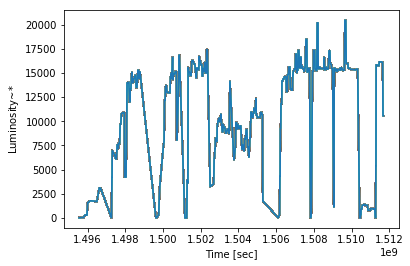

In [9]:
# luminosity
plt.plot(time, lumi)
plt.ylabel('Luminosity~$*~10^{-34}$')
plt.xlabel('Time [sec]')
plt.show()

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:380: MatplotlibDeprecationWarning: 
cycling among columns of inputs with non-matching shapes is deprecated.
  cbook.warn_deprecated("2.2", "cycling among columns of inputs "


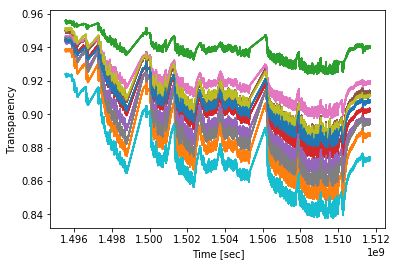

In [15]:
# transparency
plt.plot(time, transparency[:,0:10])
plt.ylabel('Transparency')
plt.xlabel('Time [sec]')
plt.show()

In [0]:
# time in fill
plt.plot(time_in_fill, transparency)
plt.ylabel('Time in Fill')
plt.xlabel('Time [sec]')
plt.show()

# A simple DNN application example

We consider one crystal as the training dataset.
The target is the transparency at thhe next readout, given
- the transparency of the last 5 readouts
- their time 
- their time in fill
- the luminosity
- the time of the next readout
- the time in fill of the next readout
- the lumi of the next readout

In [0]:
my_transparency = transparency[:,0]
my_time = time[:,0]
my_time_in_fill = time_in_fill[:,0]
my_lumi = lumi[:,0]

In [101]:
# n_readouts * (transparency, time, time in fill, luminosity) + 3 features for next readout = n_readouts*4+3 features
n_readouts = 20
total_readouts_training = my_transparency.shape[0]-n_readouts
#X = np.array([])
X_past = np.zeros((total_readouts_training,n_readouts,4))
X_current = np.zeros((total_readouts_training,3))
Y = my_transparency[n_readouts:]
TimeY = my_time[n_readouts:]
for i in range(n_readouts,my_transparency.shape[0]):
    i_out = i-n_readouts
    X_past[i_out,:,0] = my_transparency[i-n_readouts:i]
    X_past[i_out,:,1] = my_time[i-n_readouts:i]
    X_past[i_out,:,2] = my_time_in_fill[i-n_readouts:i]
    X_past[i_out,:,3] = my_lumi[i-n_readouts:i]
    X_current[i_out,:] = np.array([my_time[i],my_time_in_fill[i],my_lumi[i]])
    
    #mydata = np.array(my_transparency[i-n_readouts:i])
    #mydata = np.concatenate((mydata,my_time[i-n_readouts:i],my_time_in_fill[i-n_readouts:i],my_lumi[i-n_readouts:i]))
    #mydata = np.concatenate((mydata, np.array([my_time[i],my_time_in_fill[i],my_lumi[i]])))
    #mydata = np.reshape(mydata, (1,mydata.shape[0]))
    #X = np.concatenate((X, mydata)) if X.size else mydata
#print(X.shape, Y.shape)
print(X_past.shape, X_current.shape, Y.shape)
X = [X_past,X_current]

(3090, 20, 4) (3090, 3) (3090,)


In [0]:
# reserve the last 504 readouts for testing
X_test = [X_in[2600:] for X_in in X]
Y_test= Y[2600:]
TimeY_test= TimeY[2600:]
X = [X_in[:2600] for X_in in X]
Y = Y[:2600]

In [106]:
# We now want to split the rest in training and validation in ~2:1 
# first, we define a mask that is true at the 3rd, 6th, 9th, ... entry
entries = np.array(range(Y.shape[0]))
one_every_three = (entries+1) % 3 == 0
two_every_three = (entries+1) % 3 != 0
print(one_every_three[:10])
print(two_every_three[:10])

# and then define the dataset
X_val = [X_in[one_every_three] for X_in in X]
Y_val = Y[one_every_three]
TimeY_val = Y[one_every_three]
X_train = [X_in[two_every_three] for X_in in X]
Y_train = Y[two_every_three]
TimeY_train = Y[two_every_three]

print([X_in.shape for X_in in X_train], [X_in.shape for X_in in X_val], [X_in.shape for X_in in X_test])
print(Y_train.shape, Y_val.shape, Y_test.shape)
print(TimeY_train.shape, TimeY_val.shape, TimeY_test.shape)

[False False  True False False  True False False  True False]
[ True  True False  True  True False  True  True False  True]
[(1734, 20, 4), (1734, 3)] [(866, 20, 4), (866, 3)] [(490, 20, 4), (490, 3)]
(1734,) (866,) (490,)
(1734,) (866,) (490,)


# Model definition and training

In [0]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Dropout, Concatenate, Reshape, BatchNormalization, Activation, Conv1D, GRU, LSTM, Flatten, Concatenate
from keras.layers import MaxPooling2D
from keras.utils import plot_model
from keras import regularizers
from keras import backend as K
from keras import metrics
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [0]:

input_0 = Input(name='input_0',shape=(X_train[0].shape[1],X_train[0].shape[2],))
input_1 = Input(name='input_1',shape=(X_train[1].shape[1],))

x = BatchNormalization(name='batchnorm_1')(input_0)

x = LSTM(64, name='lstm_1')(x)
#x = GRU(32, name='gru_1')(x)
#x = Conv1D(32, kernel_size=4, strides=1, padding='same', activation='linear', name='conv1d_1')(x)
#x = BatchNormalization(name='batchnorm_2')(x)
#x = Activation("relu",name='relu_1')(x)
#x = Conv1D(32, kernel_size=4, strides=1, padding='same', activation='linear', name='conv1d_2')(x)
#x = BatchNormalization(name='batchnorm_3')(x)
#x = Activation("relu",name='relu_2')(x)
#x = Flatten(name='flatten_1')(x)

y = BatchNormalization(name='batchnorm_4')(input_1)
#y = Dense(32, kernel_initializer='lecun_uniform', name='dense_1', activation='linear')(y)
#y = BatchNormalization(name='batchnorm_5')(y)
#y = Activation("relu",name='relu_3')(y)

z = Concatenate(name='concat_1')([x,y])
z = Dense(64, kernel_initializer='lecun_uniform', name='dense_2', activation='linear')(z)
z = BatchNormalization(name='batchnorm_6')(z)
z = Activation("relu",name='relu_4')(z)
z = Dense(32, kernel_initializer='lecun_uniform', name='dense_3', activation='linear')(z)
z = BatchNormalization(name='batchnorm_7')(z)
z = Activation("relu",name='relu_5')(z)

outputLayer = Dense(1, activation='linear', kernel_initializer='lecun_uniform', name = 'output')(z)
model = Model(inputs=[input_0, input_1], outputs=outputLayer) 

In [217]:
import tensorflow as tf
def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true, y_pred)


model.compile(optimizer='adam', loss=huber_loss)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_0 (InputLayer)            (None, 20, 4)        0                                            
__________________________________________________________________________________________________
batchnorm_1 (BatchNormalization (None, 20, 4)        16          input_0[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 64)           17664       batchnorm_1[0][0]                
__________________________________________________________________________________________________
batchnorm_

In [218]:
# train 
history = model.fit(X_train, Y_train, epochs=500, batch_size=128, verbose = 2,
                  validation_data=(X_val, Y_val),
                 callbacks = [
                EarlyStopping(monitor='val_loss', patience=20, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Train on 1734 samples, validate on 866 samples
Epoch 1/500
 - 10s - loss: 0.1745 - val_loss: 0.0706
Epoch 2/500
 - 0s - loss: 0.0378 - val_loss: 0.0230
Epoch 3/500
 - 0s - loss: 0.0084 - val_loss: 0.0192
Epoch 4/500
 - 0s - loss: 0.0049 - val_loss: 0.0107
Epoch 5/500
 - 0s - loss: 0.0028 - val_loss: 0.0098
Epoch 6/500
 - 0s - loss: 0.0022 - val_loss: 0.0062
Epoch 7/500
 - 0s - loss: 0.0019 - val_loss: 0.0061
Epoch 8/500
 - 0s - loss: 0.0017 - val_loss: 0.0051
Epoch 9/500
 - 0s - loss: 0.0014 - val_loss: 0.0031
Epoch 10/500
 - 0s - loss: 0.0013 - val_loss: 0.0017
Epoch 11/500
 - 0s - loss: 0.0014 - val_loss: 0.0017
Epoch 12/500
 - 0s - loss: 0.0012 - val_loss: 0.0019

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 13/500
 - 0s - loss: 0.0012 - val_loss: 0.0018
Epoch 14/500
 - 0s - loss: 0.0011 - val_loss: 0.0014
Epoch 15/500
 - 0s - loss: 0.0012 - val_loss: 0.0011
Epoch 16/500
 - 0s - loss: 9.2151e-04 - val_loss: 0.0010
Epoch 17/500
 - 0s - loss: 

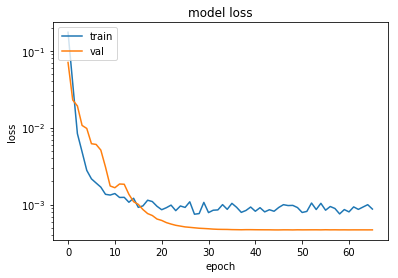

In [219]:
import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.semilogy()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [0]:
Y_hat = model.predict(X_test)
Y_hat = np.reshape(Y_hat,(Y_hat.shape[0],))

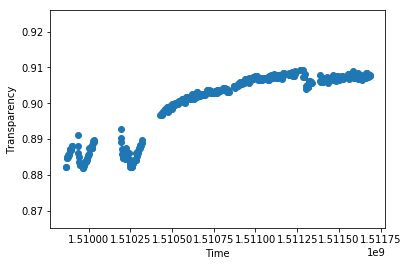

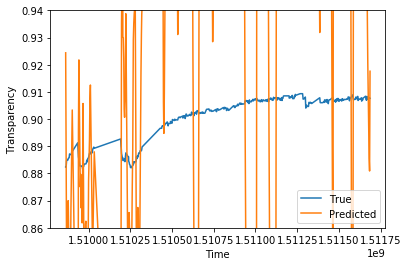

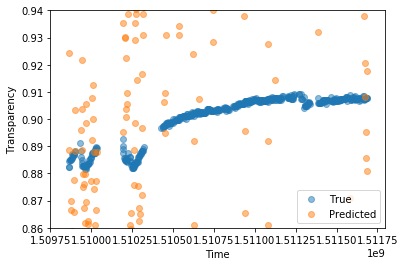

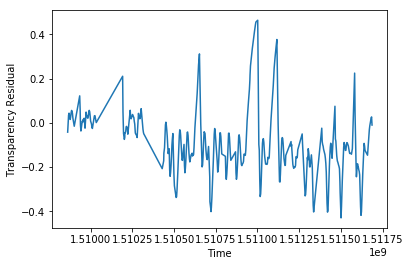

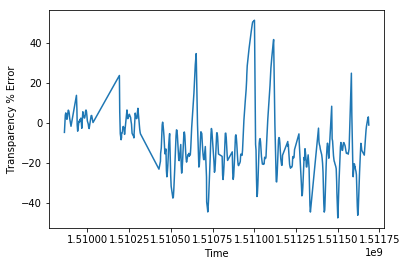

In [221]:
# true distribution
plt.scatter(TimeY_test,Y_test, label = "True")
plt.ylabel('Transparency')
plt.xlabel('Time')
plt.show()

# true distribution
plt.plot(TimeY_test,Y_test, label = "True")
plt.plot(TimeY_test,Y_hat, label = "Predicted")
plt.ylabel('Transparency')
plt.xlabel('Time')
plt.legend()
plt.ylim((0.86,0.94))
plt.show()

# true distribution
plt.scatter(TimeY_test,Y_test, label = "True", alpha=0.5)
plt.scatter(TimeY_test,Y_hat, label = "Predicted", alpha=0.5)
plt.ylabel('Transparency')
plt.xlabel('Time')
plt.legend()
plt.ylim((0.86,0.94))
plt.show()


plt.plot(TimeY_test,Y_test-Y_hat, label = "Residual")
plt.ylabel('Transparency Residual')
plt.xlabel('Time')
plt.show()

plt.plot(TimeY_test,(Y_test-Y_hat)/Y_test*100, label = "Residual")
plt.ylabel('Transparency % Error')
plt.xlabel('Time')
plt.show()